In [2]:
import pandas as pd
import numpy as np
import pathlib
from tqdm.notebook import tqdm
import librosa
import awkward as ak
import matplotlib.pyplot as plt
from IPython.display import Audio 
from collections import defaultdict
from scipy.signal import decimate # works only with audio data

Shape

In [3]:
# Read the TS continous values
X_train = np.load("../../RavdessAudioOnlyNumpy__X_train.npy")
X_test = np.load("../../RavdessAudioOnlyNumpy__X_test.npy")
print(X_train.shape, X_test.shape)

(1828, 304304) (634, 304304)


In [4]:
# Conta i valori nulli in ciascuna time series
null_counts = np.sum(np.isnan(X_train), axis=1)

# Calcola il numero di time series con valori nulli
num_series_with_nulls = np.sum(null_counts > 0)

print("Numero di time series con valori nulli:", num_series_with_nulls)

Numero di time series con valori nulli: 1827


In [5]:
# Conta i valori nulli in ciascuna time series
null_counts = np.sum(np.isnan(X_train), axis=1)

# Calcola il numero di time series senza valori nulli
num_series_without_nulls = np.sum(null_counts == 0)

print("Numero di time series senza valori nulli:", num_series_without_nulls)

Numero di time series senza valori nulli: 1


In [6]:
# Conta i valori nulli in ciascuna colonna
null_counts = np.sum(np.isnan(X_train), axis=0)

# Calcola il numero di colonne con valori nulli
num_columns_with_nulls = np.sum(null_counts > 0)

print("Numero di colonne con valori nulli:", num_columns_with_nulls)

Numero di colonne con valori nulli: 163363


In [7]:
X_train

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,  0.00000000e+00, -3.05175781e-05, ...,
                    nan,             nan,             nan],
       [ 3.05175781e-05,  3.05175781e-05,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                    nan,             nan,             nan]])

In [8]:
# Ottieni le dimensioni delle serie temporali nel dataset
series_lengths = np.array([len(series) for series in X_train])

# Controlla se tutte le serie temporali hanno la stessa lunghezza
same_length = (series_lengths == series_lengths[0]).all()

if same_length:
    print("Tutte le serie temporali hanno la stessa lunghezza.")
else:
    print("Le serie temporali hanno lunghezze diverse.")

Tutte le serie temporali hanno la stessa lunghezza.


Vedo che succede se elimino i valori nulli

In [9]:
X_train_c = X_train.copy()

In [10]:
X_train_c

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,  0.00000000e+00, -3.05175781e-05, ...,
                    nan,             nan,             nan],
       [ 3.05175781e-05,  3.05175781e-05,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                    nan,             nan,             nan],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
                    nan,             nan,             nan]])

In [11]:
# Trova le righe che contengono valori nulli
rows_with_nulls = np.isnan(X_train_c).any(axis=1)

# Filtra le righe senza valori nulli
data_nonull = X_train_c[~rows_with_nulls, :]


In [12]:
data_nonull.shape


(1, 304304)

Tutte le serie temporali hanno la stessa lunghezza quindi i valori nulli e infiniti servono per farsi che queste abbiano la stessa lunghezza
Inoltre , se elimino i valori nulli mi ritrovo solamente con un record.
Elimino dunque solo i time stamps con i valori nulli e vedo cosa cambia 

In [13]:
# Trova le colonne che contengono valori nulli
col_with_nulls = np.isnan(X_train_c).any(axis = 0)

# Filtra le colonne senza valori nulli
data_nonull_col = X_train_c[:,~col_with_nulls]

In [14]:
# Ottieni le dimensioni delle serie temporali nel dataset
series_lengths = np.array([len(series) for series in data_nonull_col])

# Controlla se tutte le serie temporali hanno la stessa lunghezza
same_length = (series_lengths == series_lengths[0]).all()

if same_length:
    print("Tutte le serie temporali hanno la stessa lunghezza.")
else:
    print("Le serie temporali hanno lunghezze diverse.")

Tutte le serie temporali hanno la stessa lunghezza.


Eliminando le colonne con valori nulli so che tutte hanno hanno la stessa lunghezza 

Statistiche di base 

In [15]:
print("Media:", np.mean(data_nonull_col))
print("Mediana:", np.median(data_nonull_col))
print("Deviazione standard:", np.std(data_nonull_col))
print("Valore minimo:", np.min(data_nonull_col))
print("Valore massimo:", np.max(data_nonull_col))

Media: -6.130212023128306e-07
Mediana: 0.0
Deviazione standard: 0.03195011473889501
Valore minimo: -0.998809814453125
Valore massimo: 0.9991455078125


Un poì di grafici

Serie temporali con valori nulli

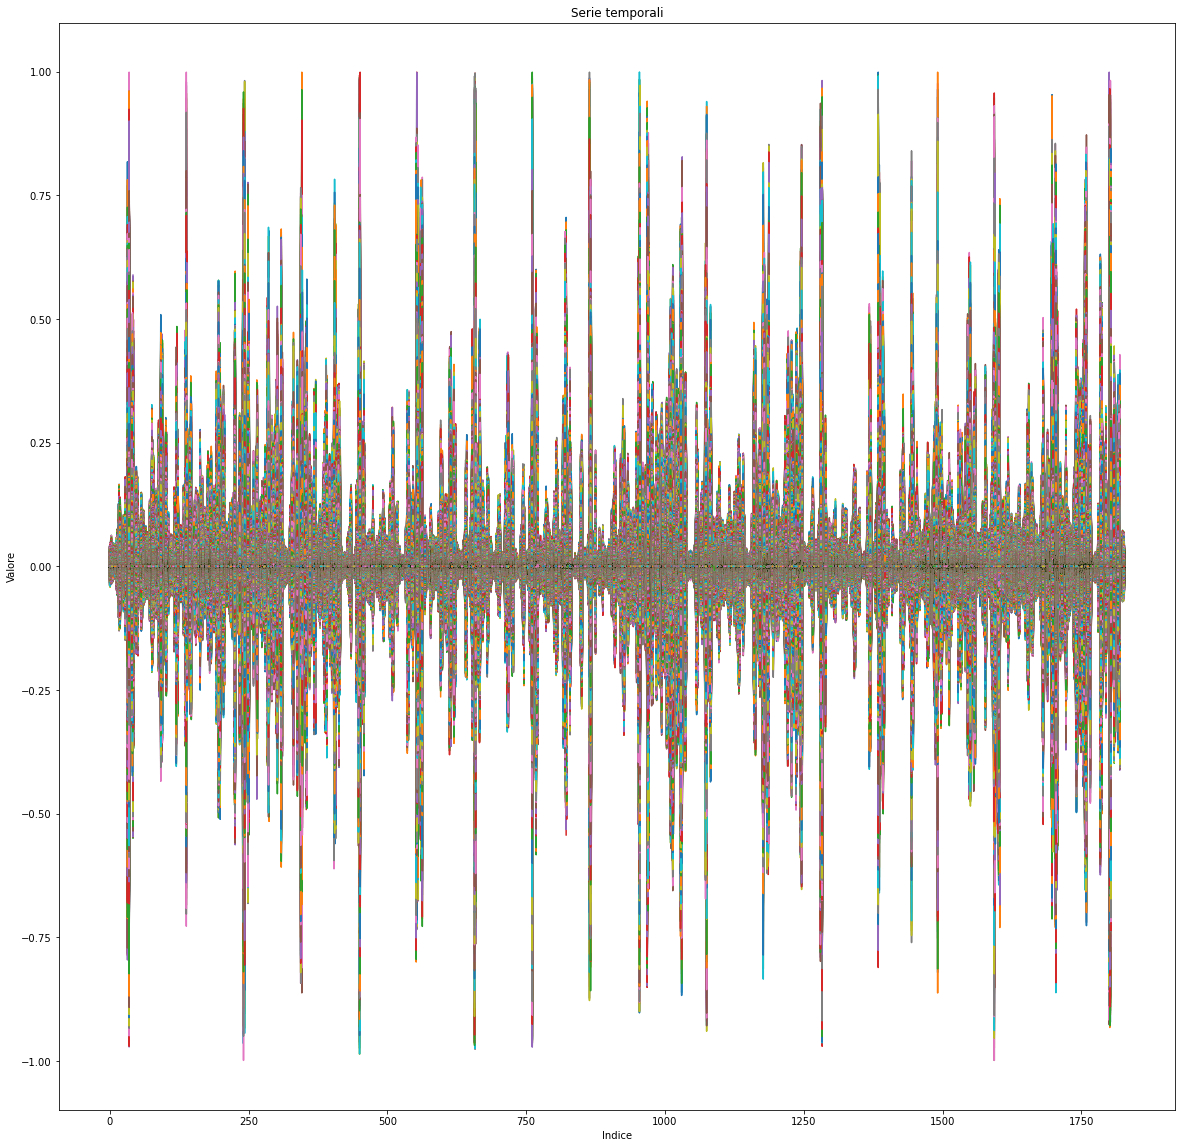

In [16]:
plt.figure(figsize=(20,20))
plt.plot(X_train)
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.title("Serie temporali")
plt.show()

Serie temporali senza valori nulli

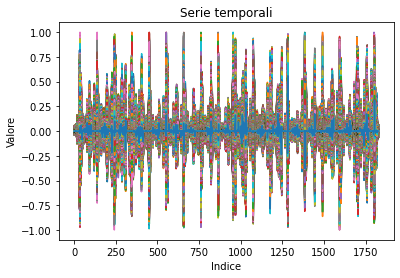

In [34]:
plt.plot(data_nonull_col)
plt.xlabel("Indice")
plt.ylabel("Valore")
plt.title("Serie temporali")
plt.show()

In [1]:
import scipy.stats as stats

In [12]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [13]:
features = calculate_features(X_train)

In [14]:
features

{'avg': nan,
 'std': nan,
 'var': nan,
 'med': nan,
 '10p': nan,
 '25p': nan,
 '50p': nan,
 '75p': nan,
 '90p': nan,
 'iqr': nan,
 'cov': nan,
 'skw': array([13.16169154, 24.08100887, 27.43145277, ...,         nan,
                nan,         nan]),
 'kur': array([ 781.07396443, 1037.91772824, 1159.37432405, ...,           nan,
                  nan,           nan])}

In [15]:
features = calculate_features(data_nonull_col)

In [16]:
features

{'avg': -6.130212023128306e-07,
 'std': 0.03195011473889501,
 'var': 0.0010208098318285562,
 'med': 0.0,
 '10p': -0.014190673828125,
 '25p': -0.00115966796875,
 '50p': 0.0,
 '75p': 0.00152587890625,
 '90p': 0.014068603515625,
 'iqr': 0.002685546875,
 'cov': -1.918682318741594e-05,
 'skw': array([13.16169154, 24.08100887, 27.43145277, ...,  5.85249532,
         4.28367084,  2.0982881 ]),
 'kur': array([ 781.07396443, 1037.91772824, 1159.37432405, ...,  166.97384451,
         120.86112148,   75.72637435])}

In [29]:
data_nonull_col.shape

(1828, 140941)

Analisi del test set 

In [30]:
# Conta i valori nulli in ciascuna time series
null_counts = np.sum(np.isnan(X_test), axis=1)

# Calcola il numero di time series con valori nulli
num_series_with_nulls = np.sum(null_counts > 0)

print("Numero di time series con valori nulli:", num_series_with_nulls)

Numero di time series con valori nulli: 633


In [35]:
# Conta i valori nulli in ciascuna colonna
null_counts = np.sum(np.isnan(X_test), axis=0)

# Calcola il numero di colonne con valori nulli
num_columns_with_nulls = np.sum(null_counts > 0)

print("Numero di colonne con valori nulli:", num_columns_with_nulls)

Numero di colonne con valori nulli: 156956


In [33]:
X_test

array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [-0.00018311, -0.00018311, -0.00018311, ...,         nan,
                nan,         nan],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan]])

In [34]:
# Ottieni le dimensioni delle serie temporali nel dataset
series_lengths = np.array([len(series) for series in X_test])

# Controlla se tutte le serie temporali hanno la stessa lunghezza
same_length = (series_lengths == series_lengths[0]).all()

if same_length:
    print("Tutte le serie temporali hanno la stessa lunghezza.")
else:
    print("Le serie temporali hanno lunghezze diverse.")

Tutte le serie temporali hanno la stessa lunghezza.


Salvo gli indici delle colonne aventi valori nulli

In [36]:
# Individua le colonne con valori nulli
col_with_nulls = np.isnan(X_train).any(axis=0)

# Ottieni gli indici delle colonne con valori nulli
indices_with_nulls = np.where(col_with_nulls)[0]

print("Indici delle colonne con valori nulli:", indices_with_nulls)

Indici delle colonne con valori nulli: [140941 140942 140943 ... 304301 304302 304303]


In [37]:
X_test_c = X_test.copy()

In [38]:
X_test_c

array([[ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [-0.00018311, -0.00018311, -0.00018311, ...,         nan,
                nan,         nan],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan]])

Elimino questi indici dal test set 

In [39]:
data_test_without_nulls = np.delete(X_test_c, indices_with_nulls, axis=1)


In [40]:
data_test_without_nulls.shape

(634, 140941)

In [45]:
# Conta i valori nulli in ciascuna time series
null_counts = np.sum(np.isnan(data_test_without_nulls), axis=1)

# Calcola il numero di time series con valori nulli
num_series_with_nulls = np.sum(null_counts > 0)

print("Numero di time series con valori nulli:", num_series_with_nulls)

Numero di time series con valori nulli: 0


Da scaricare  le seguenti variabili : data_test_without_nulls , data_nonull_col

### MOTIFS AND ANOMALIES DISCOVERY

In [162]:
from matrixprofile import *



In [134]:
#Proviamo con la clama indice 4
data_nonull_col[4]


array([3.11305993e-05, 6.13021202e-07, 6.13021202e-07, ...,
       6.13021202e-07, 6.13021202e-07, 6.13021202e-07])

In [169]:
w = 100
mp, mpi = matrixProfile.stomp(data_nonull_col[4].values, w)

plt.plot(mp)
plt.show()

NameError: name 'matrixProfile' is not defined